# Feature Engineering: Preparazione del Dataset per il Machine Learning

In questo notebook effettuiamo il passaggio cruciale dal **Data Cleaning** alla creazione del dataset finale pronto per l'addestramento.

L'obiettivo è trasformare le feature dei film in valori numerici elaborabili dai modelli, gestire le variabili categoriche ad alta cardinalità e preparare il train/test split.

Il target `success` è già stato definito nell'EDA_Cleaning come classificazione **binaria**:
- **1 (Successo)**: ROI ≥ 2.0 *e* vote_average ≥ 6.0
- **0 (Flop)**: tutti gli altri casi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. Caricamento del Dataset Pulito

Carichiamo `dataset_pulito.csv` generato dall'EDA_Cleaning.
Questo file è privo di valori nulli e contiene già la variabile target `success`.

In [2]:
df = pd.read_csv('../data/processed/dataset_pulito.csv')

print(f"Dataset caricato: {df.shape[0]} film, {df.shape[1]} colonne")
print("\nColonne disponibili:")
print(df.columns.tolist())
print(f"\nDistribuzione target 'success':")
print(df['success'].value_counts())
print(f"\nTasso di successo: {df['success'].mean()*100:.1f}%")

Dataset caricato: 3229 film, 28 colonne

Colonne disponibili:
['budget', 'id', 'original_language', 'popularity', 'revenue', 'runtime', 'title', 'vote_average', 'vote_count', 'genres_list', 'main_genre', 'keywords_list', 'companies_list', 'main_company', 'countries_list', 'languages_list', 'lead_actor', 'top3_cast', 'cast_size', 'director', 'roi', 'success', 'release_year', 'release_month', 'release_season', 'n_genres', 'n_keywords', 'is_english']

Distribuzione target 'success':
success
0    1854
1    1375
Name: count, dtype: int64

Tasso di successo: 42.6%


## 2. Prevenzione del Data Leakage

Il target `success` è stato costruito a partire da `roi` (che dipende da `revenue`) e da `vote_average`.
Queste colonne **non possono essere usate come feature di input**: il modello conoscerebbe già la risposta.

- `revenue` → conseguenza del successo, non causa
- `roi` → costruito da revenue/budget, contiene revenue
- `vote_average` e `vote_count` → disponibili solo *dopo* l'uscita del film

Manteniamo `budget` (investimento *a priori*) e `popularity` (indice TMDB legato anche all'hype pre-uscita).

In [3]:
#colonne che causerebbero data leakage
colonne_leakage = ['revenue', 'roi', 'vote_average', 'vote_count']

#colonne identificative o con dati strutturati già ingegnerizzati
colonne_non_utili = [
    'id', 'title', 'original_language',
    'genres_list', 'keywords_list', 'companies_list',
    'countries_list', 'languages_list', 'top3_cast'
]

df_ml = df.drop(columns=[c for c in colonne_leakage + colonne_non_utili if c in df.columns])

print(f"Colonne rimosse per leakage: {[c for c in colonne_leakage if c in df.columns]}")
print(f"Colonne rimosse perché non utili: {[c for c in colonne_non_utili if c in df.columns]}")
print(f"\nColonne rimaste ({df_ml.shape[1]}):")
print(df_ml.columns.tolist())

Colonne rimosse per leakage: ['revenue', 'roi', 'vote_average', 'vote_count']
Colonne rimosse perché non utili: ['id', 'title', 'original_language', 'genres_list', 'keywords_list', 'companies_list', 'countries_list', 'languages_list', 'top3_cast']

Colonne rimaste (15):
['budget', 'popularity', 'runtime', 'main_genre', 'main_company', 'lead_actor', 'cast_size', 'director', 'success', 'release_year', 'release_month', 'release_season', 'n_genres', 'n_keywords', 'is_english']


## 3. Codifica delle Variabili Categoriche

I modelli ML richiedono input numerici. Adottiamo strategie diverse in base alla cardinalità:

- **`main_genre`** e **`release_season`** → cardinalità bassa (< 20 valori) → **One-Hot Encoding**
- **`director`**, **`lead_actor`**, **`main_company`** → centinaia di valori unici → **Target Encoding**

Il **Target Encoding** sostituisce ogni categoria con la percentuale storica di successo di quella categoria.
Cattura il "peso" di un regista o attore senza far esplodere le dimensioni del dataset.

> **Nota sul leakage nel Target Encoding**: idealmente andrebbe calcolato solo sul training set
> per poi applicarlo al test. Qui lo calcoliamo sull'intero dataset come approssimazione;
> nel notebook di training viene gestito correttamente all'interno della pipeline.

In [4]:
#One-Hot Encoding
colonne_ohe = ['main_genre', 'release_season']
colonne_ohe = [c for c in colonne_ohe if c in df_ml.columns]

df_ml = pd.get_dummies(df_ml, columns=colonne_ohe, drop_first=False)

#conversione bool --> int (pandas >= 1.5 produce bool con get_dummies)
bool_cols = df_ml.select_dtypes(include='bool').columns
df_ml[bool_cols] = df_ml[bool_cols].astype(int)

print(f"One-Hot Encoding applicato a: {colonne_ohe}")
print(f"Colonne dopo OHE: {df_ml.shape[1]}")

One-Hot Encoding applicato a: ['main_genre', 'release_season']
Colonne dopo OHE: 37


In [5]:
#Target Encoding
colonne_te = ['director', 'lead_actor', 'main_company']
colonne_te = [c for c in colonne_te if c in df_ml.columns]

for col in colonne_te:
    mapping = df_ml.groupby(col)['success'].mean()
    df_ml[col + '_te'] = df_ml[col].map(mapping).fillna(df_ml['success'].mean())
    df_ml = df_ml.drop(columns=[col])
    print(f"  Target encoding: '{col}' → '{col}_te'")

print(f"\nColonne finali ({df_ml.shape[1]}):")
print(df_ml.columns.tolist())

  Target encoding: 'director' → 'director_te'
  Target encoding: 'lead_actor' → 'lead_actor_te'
  Target encoding: 'main_company' → 'main_company_te'

Colonne finali (37):
['budget', 'popularity', 'runtime', 'cast_size', 'success', 'release_year', 'release_month', 'n_genres', 'n_keywords', 'is_english', 'main_genre_Action', 'main_genre_Adventure', 'main_genre_Animation', 'main_genre_Comedy', 'main_genre_Crime', 'main_genre_Documentary', 'main_genre_Drama', 'main_genre_Family', 'main_genre_Fantasy', 'main_genre_Foreign', 'main_genre_History', 'main_genre_Horror', 'main_genre_Music', 'main_genre_Mystery', 'main_genre_Romance', 'main_genre_Science Fiction', 'main_genre_Thriller', 'main_genre_Unknown', 'main_genre_War', 'main_genre_Western', 'release_season_Fall', 'release_season_Spring', 'release_season_Summer', 'release_season_Winter', 'director_te', 'lead_actor_te', 'main_company_te']


## 4. Analisi della Correlazione con il Target

Prima dello split analizziamo visivamente quali feature hanno la maggiore correlazione lineare
con la variabile target. Questo ci dà un'indicazione delle feature più predittive.

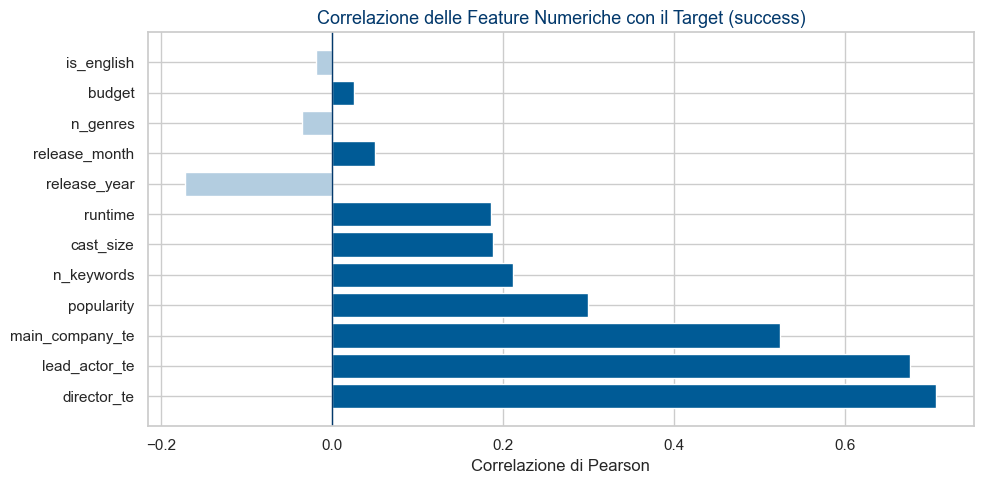


Correlazioni ordinate per valore assoluto:
director_te        0.707291
lead_actor_te      0.675951
main_company_te    0.524124
popularity         0.299585
n_keywords         0.211218
cast_size          0.188742
runtime            0.186349
release_year      -0.172107
release_month      0.050570
n_genres          -0.035063
budget             0.025345
is_english        -0.019074


In [6]:
sns.set_theme(style='whitegrid', palette='Blues_r')

# Prendiamo solo le colonne numeriche (escludiamo le OHE per leggibilità)
cols_base = ['budget', 'popularity', 'runtime', 'release_year', 'release_month',
             'n_genres', 'n_keywords', 'cast_size', 'is_english',
             'director_te', 'lead_actor_te', 'main_company_te']
cols_base = [c for c in cols_base if c in df_ml.columns]

corr_target = (
    df_ml[cols_base + ['success']]
    .corr()['success']
    .drop('success')
    .sort_values(key=abs, ascending=False)
)

plt.figure(figsize=(10, 5))
colori = ['#005b96' if v > 0 else '#b3cde0' for v in corr_target.values]
plt.barh(corr_target.index, corr_target.values, color=colori)
plt.axvline(x=0, color='#03396c', linewidth=1)
plt.title('Correlazione delle Feature Numeriche con il Target (success)',
          fontsize=13, color='#03396c')
plt.xlabel('Correlazione di Pearson')
plt.tight_layout()
plt.savefig('../docs/feature_correlation_target.png', bbox_inches='tight')
plt.show()

print("\nCorrelazioni ordinate per valore assoluto:")
print(corr_target.to_string())

## 5. Definizione di X e y — Train/Test Split Stratificato

Separiamo le feature (X) dal target (y) ed eseguiamo uno split **80% training / 20% test**.

Usiamo `stratify=y` per garantire che entrambi i set mantengano la stessa proporzione di film
di successo rispetto al dataset originale, dato che classi non sono perfettamente bilanciate.

In [7]:
X = df_ml.drop(columns=['success'])
y = df_ml['success']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set : {X_train.shape[0]} film, {X_train.shape[1]} feature")
print(f"Test set     : {X_test.shape[0]} film, {X_test.shape[1]} feature")
print(f"\n--- Verifica Stratificazione ---")
print(f"Tasso successo nel Training set : {y_train.mean()*100:.1f}%")
print(f"Tasso successo nel Test set     : {y_test.mean()*100:.1f}%")
print(f"Tasso successo nel dataset originale: {y.mean()*100:.1f}%")

Training set : 2583 film, 36 feature
Test set     : 646 film, 36 feature

--- Verifica Stratificazione ---
Tasso successo nel Training set : 42.6%
Tasso successo nel Test set     : 42.6%
Tasso successo nel dataset originale: 42.6%


## 6. Visualizzazione del Bilanciamento delle Classi

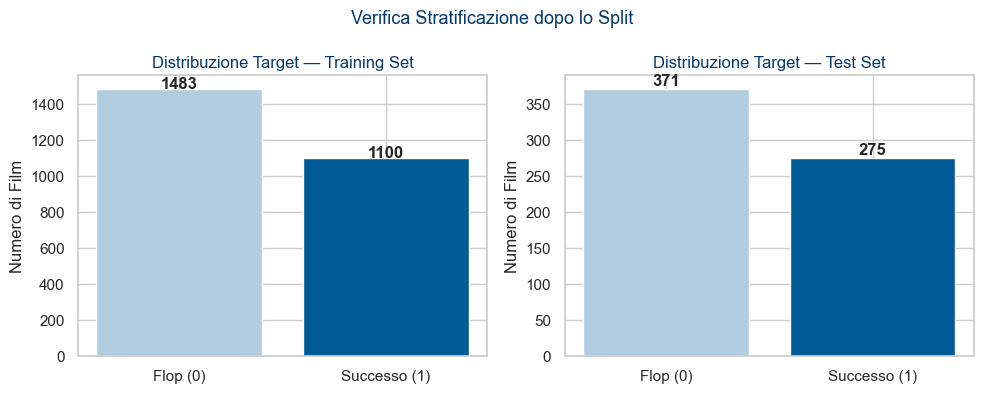

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, y_set, titolo in zip(axes, [y_train, y_test], ['Training Set', 'Test Set']):
    conteggi = y_set.value_counts().sort_index()
    ax.bar(['Flop (0)', 'Successo (1)'], conteggi.values, color=['#b3cde0', '#005b96'])
    ax.set_title(f'Distribuzione Target — {titolo}', color='#03396c')
    ax.set_ylabel('Numero di Film')
    for i, v in enumerate(conteggi.values):
        ax.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.suptitle('Verifica Stratificazione dopo lo Split', fontsize=13, color='#03396c')
plt.tight_layout()
plt.savefig('../docs/class_balance_split.png', bbox_inches='tight')
plt.show()

## 7. Normalizzazione con StandardScaler

Alcuni modelli (Logistic Regression, SVM) sono sensibili alla scala delle feature:
variabili con range molto diversi (budget in milioni vs runtime in minuti) possono
distorcere l'apprendimento.

Applichiamo dunque `StandardScaler` che porta ogni feature a media 0 e deviazione standard 1.

**Regola fondamentale anti-leakage:**
- `fit_transform` → **solo sul training set** (calcola media e std dai dati di training)
- `transform` → **solo sul test set** (applica i parametri del training, non ne calcola di nuovi)

In [9]:
colonne_da_scalare = [
    'budget', 'popularity', 'runtime',
    'release_year', 'release_month',
    'n_genres', 'n_keywords', 'cast_size'
]
colonne_da_scalare = [c for c in colonne_da_scalare if c in X_train.columns]

scaler = StandardScaler()
X_train = X_train.copy()
X_test  = X_test.copy()

X_train[colonne_da_scalare] = scaler.fit_transform(X_train[colonne_da_scalare])
X_test[colonne_da_scalare]  = scaler.transform(X_test[colonne_da_scalare])

print(f"StandardScaler applicato a: {colonne_da_scalare}")
print("\nStatistiche post-scaling (Training set):")
print(X_train[colonne_da_scalare].describe().loc[['mean', 'std']].round(3))

StandardScaler applicato a: ['budget', 'popularity', 'runtime', 'release_year', 'release_month', 'n_genres', 'n_keywords', 'cast_size']

Statistiche post-scaling (Training set):
      budget  popularity  runtime  release_year  release_month  n_genres  \
mean    -0.0         0.0     -0.0           0.0           -0.0      -0.0   
std      1.0         1.0      1.0           1.0            1.0       1.0   

      n_keywords  cast_size  
mean        -0.0       -0.0  
std          1.0        1.0  


## 8. Salvataggio del Dataset

Salviamo il dataset con le feature ingegnerizzate e la colonna `success`.
Nel notebook di model training ricaricheremo questo file e rieseguiremo lo split con lo stesso `random_state=42`
per garantire la riproducibilità.

In [10]:
path_features = '../data/processed/dataset_features.csv'
df_ml.to_csv(path_features, index=False)

print(f"Dataset per il Machine Learning salvato in: {path_features}")
print(f"Shape: {df_ml.shape}")
print(f"\nRiepilogo colonne finali:")
for col in df_ml.columns:
    print(f"  - {col} ({df_ml[col].dtype})")

Dataset per il Machine Learning salvato in: ../data/processed/dataset_features.csv
Shape: (3229, 37)

Riepilogo colonne finali:
  - budget (int64)
  - popularity (float64)
  - runtime (float64)
  - cast_size (int64)
  - success (int64)
  - release_year (int64)
  - release_month (int64)
  - n_genres (int64)
  - n_keywords (int64)
  - is_english (int64)
  - main_genre_Action (int64)
  - main_genre_Adventure (int64)
  - main_genre_Animation (int64)
  - main_genre_Comedy (int64)
  - main_genre_Crime (int64)
  - main_genre_Documentary (int64)
  - main_genre_Drama (int64)
  - main_genre_Family (int64)
  - main_genre_Fantasy (int64)
  - main_genre_Foreign (int64)
  - main_genre_History (int64)
  - main_genre_Horror (int64)
  - main_genre_Music (int64)
  - main_genre_Mystery (int64)
  - main_genre_Romance (int64)
  - main_genre_Science Fiction (int64)
  - main_genre_Thriller (int64)
  - main_genre_Unknown (int64)
  - main_genre_War (int64)
  - main_genre_Western (int64)
  - release_season_Fall